# Cadenas de Algoritmos y Pipelines

- Para muchos algoritmos de aprendizaje automático, la representación particular de los datos que proporciona es muy importante, como ya comentamos anterioremente. Esto comienza con el escalado de los datos y la combinación de características a mano y llega hasta el aprendizaje de características utilizando el aprendizaje automático no supervisado. En consecuencia, `la mayoría de las aplicaciones de aprendizaje automático requieren no sólo la aplicación de un único algoritmo sino el encadenamiento de muchos pasos de procesamiento y modelos de aprendizaje automático diferentes`. En este capítulo, veremos cómo utilizar la clase `Pipeline` para simplificar el proceso de construcción de cadenas de transformaciones y modelos. En particular, veremos cómo podemos `combinar Pipeline y GridSearchCV para buscar sobre los parámetros de todos los pasos de procesamiento a la vez`. Como ejemplo de la importancia de encadenar modelos, observamos que podemos mejorar en gran medida el rendimiento de un kernel `SVM` en el conjunto de datos `cancer` utilizando el `MinMaxScaler` para el preprocesamiento.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

In [4]:
scaler = MinMaxScaler().fit(X_train)

In [5]:
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


## Selección de parámetros con preprocesamiento

- Ahora digamos que queremos encontrar mejores parámetros para el `SVC` usando `GridSearchCV`, como se ha discutido en secciones anteriores. ¿Cómo podemos hacerlo? Un enfoque ingenuo podría ser el siguiente

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [7]:
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


- En este caso, ejecutamos una búsqueda en red (`grid-search`) sobre los parámetros de `SVC` utilizando los `datos escalados`. Sin embargo, nótese que al escalar los datos, `utilizamos todos los datos del conjunto de entrenamiento`. Luego usamos los `datos de entrenamiento escalados para ejecutar nuestra búsqueda en red usando la validación cruzada`. Para cada división en la validación cruzada, recuerde que, dependiendo del número de folds, en este caso por defecto `cv=5`, alguna parte del conjunto de entrenamiento original, será declarada como la parte de entrenamiento de la división, y otra la parte de prueba. `La parte de prueba se utiliza para medir cómo el modelo clasificará nuevos datos cuando fué entrenado con datos de entrenamiento`. 

- Recuerde que, la parte de prueba de cada división en la validación cruzada es parte del conjunto de entrenamiento, y utilizamos la información de todo el conjunto de entrenamiento para encontrar el escalado correcto de los datos. Esto es fundamentalmente diferente de cómo se ven los nuevos datos para el modelo. `Si observamos datos nuevos (por ejemplo, en forma de nuestro conjunto de prueba), estos datos no se habrán utilizado para escalar los datos de entrenamiento, y podrían tener un mínimo y un máximo diferente a los de los datos de entrenamiento`. El siguiente ejemplo muestra cómo se procesan los datos durante la la validación cruzada y la evaluación final

In [8]:
import mglearn

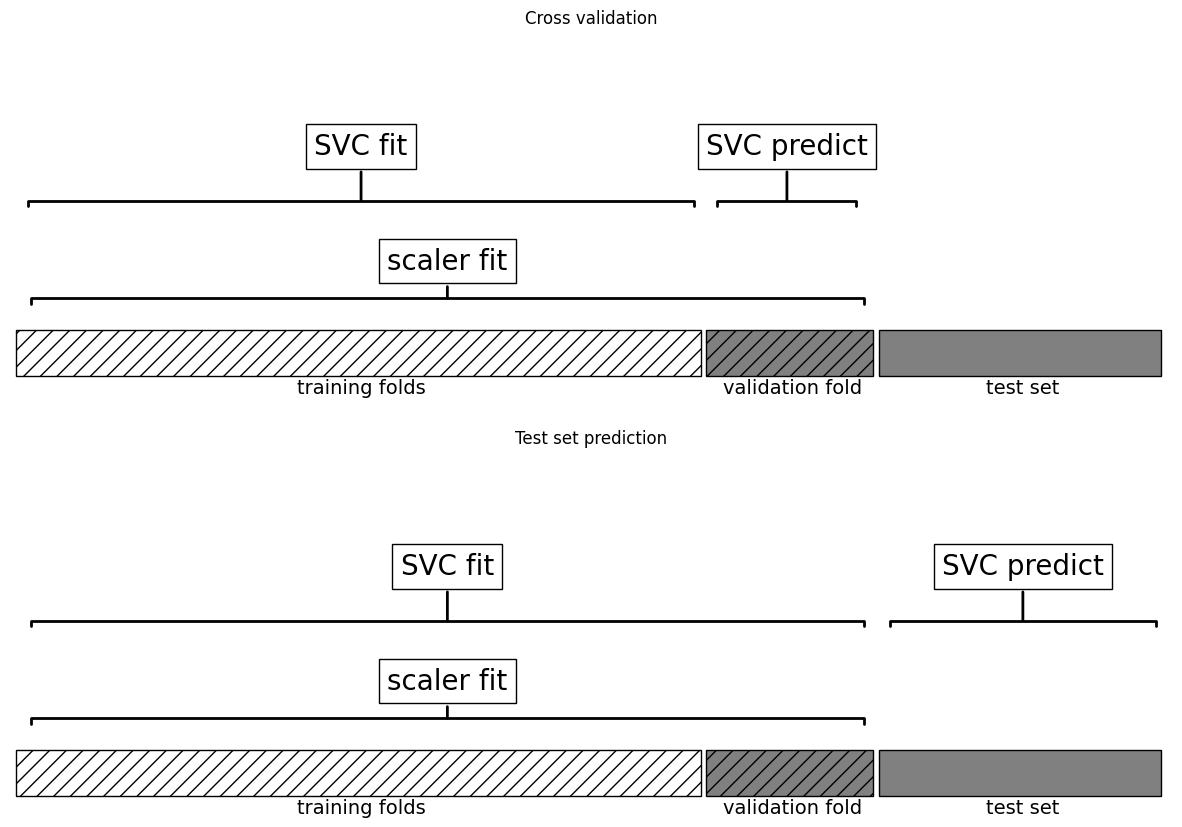

In [9]:
mglearn.plots.plot_improper_processing()

- Así, las divisiones en la validación cruzada ya no reflejan correctamente cómo se verán los nuevos datos en el proceso de modelamiento, ya que hemos filtrado información de estas partes de los datos en este proceso. Esto conducirá a resultados excesivamente optimistas durante la validación cruzada, y posiblemente, a la selección de parámetros subóptimos. `Para evitar este problema, la división del conjunto de datos durante la validación cruzada debería hacerse antes de realizar cualquier preprocesamiento`. Cualquier proceso que extraiga conocimiento del conjunto de datos sólo debe aplicarse a la parte de entrenamiento, por lo que cualquier validación cruzada debe ser el `"bucle más externo"` de su procesamiento.

- Para lograr esto en `scikit-learn` con la función `cross_val_score` y la función `GridSearchCV`, podemos utilizar la clase `Pipeline`. La clase `Pipeline es una clase que permite "pegar" múltiples pasos de procesamiento en un único estimador de scikit-learn`. La clase `Pipeline tiene métodos de ajuste, predicción y scoring, además se comporta como cualquier otro modelo en scikit-learn`. El caso de uso más común de la clase `Pipeline` es encadenar pasos de preprocesamiento (como el escalado de los datos) junto con un modelo supervisado como un clasificador.

```{admonition} Observacion
:class: tip

La `fuga de datos` es un problema para los modelos predictivos. Decimos que hay fuga de datos cuando se utilizan datos ajenos al conjunto de entrenamiento para desarrollar el modelo. `Hay fuga si se comparte información entre los conjuntos de entrenamiento y de prueba`. Si no detectamos esta forma de fuga, podemos tener resultados exagerados durante el entrenamiento. `Esto se debe a que el modelo ya está expuesto a los datos de prueba, ofreciendo así un rendimiento muy impresionante`.
```

## Construyendo Pipelines

- Veamos cómo podemos utilizar la clase `Pipeline` para expresar el flujo de trabajo para entrenar una `SVM` después de escalar los datos con `MinMaxScaler` (por ahora sin grid-search). Primero, `construimos un objeto pipeline proporcionándole una lista de pasos. Cada paso es una tupla que contiene un nombre (cualquier cadena de su elección) y una instancia de un estimador`

In [10]:
from sklearn.pipeline import Pipeline

In [11]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

- Aquí, creamos dos pasos: el primero, llamado `"scaler", es una instancia de MinMaxScaler` y el segundo, llamado `"svm", es una instancia de SVC`. Ahora, podemos ajustar nuestro pipeline, como cualquier otro estimador de `scikit-learn`

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

- Aquí, `pipe.fit` primero llama a `fit` en el primer paso (el escalador), luego transforma los datos de entrenamiento usando el escalador, y finalmente ajusta la `SVM` con los datos escalados. `Para evaluar en los datos de prueba, simplemente llamamos a pipe.score`

In [13]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


- Al llamar al método de scoring en el pipeline, primero se transforman los datos de prueba utilizando el `scaler` y luego llama al método de scoring en la `SVM` utilizando los datos de prueba escalados. Como puede, el resultado es idéntico al que obtuvimos del código al principio del
capítulo, al hacer las transformaciones a mano. `Usando el pipeline, hemos reducido el código necesario para nuestro proceso de "preprocesamiento + clasificación"`. Sin embargo, la principal ventaja de usar el `pipeline`, es que ahora podemos usar este único estimador en
`cross_val_score` o `GridSearchCV`.

## Utilizando Pipeline en GridSearch

- El uso de una tubería `(pipeline)` en una búsqueda de red `(grid-search)` funciona de la misma manera que el uso de cualquier otro estimador. `Definimos una red de parámetros en la que buscar, y construimos un GridSearchCV a partir de la tubería y la red de parámetros`. Al especificar la red de parámetros, hay un ligero cambio, sin embargo. Tenemos que especificar para cada parámetro, a qué paso de la tubería pertenece. Los dos parámetros que queremos ajustar, `C` y `gamma`, son parámetros de `SVC`, el segundo paso. A este paso le hemos dado el nombre de `"svm"`. La sintaxis para definir una red de parámetros para una tubería es especificar, para cada parámetro, el nombre del paso, seguido de `__` (un doble guión bajo), seguido del nombre del parámetro. `Para buscar en los parámetros de C de SVC tenemos que usar "svm__C" como clave en el diccionario de la red de parámetros, y lo mismo para gamma`.

In [14]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

- Con este parámetro `grid` podemos utilizar `GridSearchCV` como siempre

In [15]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


- A diferencia de la búsqueda en red que hicimos antes, ahora `para cada división en la validación cruzada el MinMaxScaler se reajusta sólo con las divisiones de entrenamiento y no se filtra información de la división de prueba en la búsqueda de parámetros`

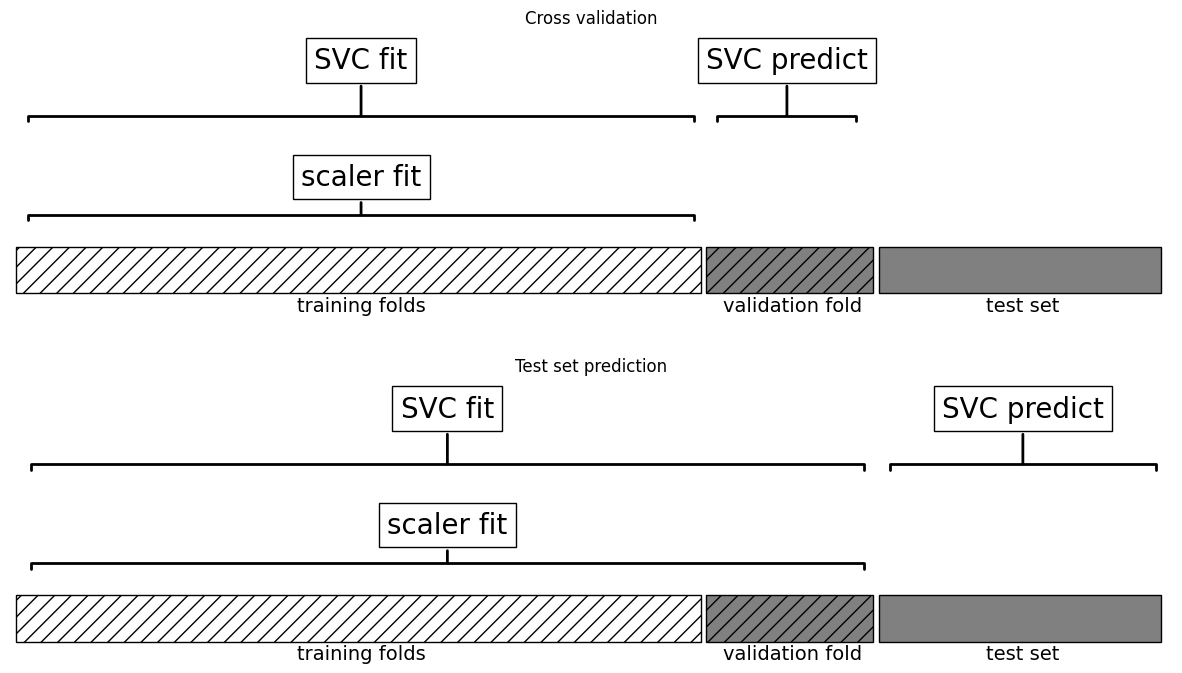

In [16]:
mglearn.plots.plot_proper_processing()

- El impacto de la fuga de información en la validación cruzada varía en función de la naturaleza del paso de preprocesamiento. `La estimación de la escala de los datos mediante el pliegue de prueba no suele tener un impacto terrible, mientras que, el uso del pliegue de prueba en la extracción de características y la selección de características puede dar lugar a diferencias sustanciales en los resultados`.

## Data Leakage

- La fuga de datos (**`data leakage`**) `se produce cuando al construir el modelo se utiliza información que no estaría disponible en el momento de la predicción`. Esto da lugar a estimaciones de rendimiento demasiado optimistas, por ejemplo, a partir de la validación cruzada, y, por tanto, a un peor rendimiento cuando el modelo se utiliza con datos realmente nuevo, por ejemplo, durante la producción.

- `Una causa común es no mantener separados los subconjuntos de datos de prueba y de entrenamiento. Los datos de prueba nunca deben utilizarse para tomar decisiones sobre el modelo`. La regla general es no llamar nunca al ajuste en los datos de prueba. Aunque esto puede parecer obvio, es fácil que se pase por alto en algunos casos, por ejemplo al aplicar ciertos pasos de preprocesamiento.

- *Aunque tanto los subconjuntos de datos de entrenamiento como los de prueba deben recibir la misma transformación de preprocesamiento, es importante que estas transformaciones sólo se aprendan de los datos de entrenamiento*. `Por ejemplo, si tiene un paso de normalización en el que se divide por el valor medio, la media debe ser la media del subconjunto de entrenamiento, no la media de todos los datos. Si el subconjunto de prueba se incluye en el cálculo del promedio, la información del subconjunto de prueba está influyendo en el modelo.`

- Hay una serie de funciones de selección de características disponibles en scikit-learn. Pueden ayudar a eliminar características irrelevantes, redundantes y ruidosas, así como a mejorar el tiempo de construcción y el rendimiento del modelo. `Al igual que con cualquier otro tipo de preprocesamiento, la selección de características sólo debe utilizar los datos de entrenamiento. Incluir los datos de prueba en la selección de características sesgará su modelo de forma optimista.` Para demostrarlo, crearemos este problema de clasificación binaria con 10.000 características generadas aleatoriamente.

In [17]:
import numpy as np
n_samples, n_features, n_classes = 200, 10000, 2
rng = np.random.RandomState(42)
X = rng.standard_normal((n_samples, n_features))
y = rng.choice(n_classes, n_samples)

**`Forma incorrecta`**

- `El uso de todos los datos para realizar la selección de características da como resultado una puntuación de precisión muy superior a la del azar, a pesar de que nuestros objetivos son completamente aleatorios`. Esta aleatoriedad significa que nuestras `X` e `y` son independientes y, por tanto, esperamos que la precisión sea de alrededor de 0.5. `Sin embargo, como el paso de selección de características "observa" los datos de prueba, el modelo tiene una ventaja injusta`. En el ejemplo incorrecto que se muestra a continuación, primero utilizamos todos los datos para la selección de características y luego dividimos los datos en subconjuntos de entrenamiento y de prueba para el ajuste del modelo. El resultado es una puntuación de precisión mucho más alta de lo esperado. 

- Aquí `SelectKBest` toma como parámetro una función de puntuación, que debe ser aplicable a un par `(X, y)`. La función de puntuación debe devolver una matriz de puntuaciones, una por cada característica `X[:,i]` de `X`. `SelectKBest` simplemente retiene las primeras `k` características de `X` con las puntuaciones más altas. Así, por ejemplo, si pasa `chi2` como función de puntuación, `SelectKBest calculará el estadístico chi2 entre cada característica de X e y. Un valor pequeño significará que la característica es independiente de y. Un valor grande significará que la característica está relacionada de forma no aleatoria con y, por lo que es probable que proporcione información importante. Sólo se conservarán k características.` Por defecto `SelectKBest` usa `f_regression F-value` entre etiqueta/característica (label/feature).

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

- `Preprocesamiento incorrecto: se transforman todos los datos`

In [19]:
X_selected = SelectKBest(k=25).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state=42)
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
accuracy_score(y_test, y_pred)

0.76

**`Forma correcta`**

- Para evitar la fuga de datos, es una buena práctica dividir primero los datos en subconjuntos de entrenamiento y de prueba. `La selección de características puede entonces formarse usando sólo el conjunto de datos de entrenamiento`. Observe que siempre que usamos `fit` o `fit_transform`, `sólo usamos el conjunto de datos de entrenamiento`. La puntuación es ahora la que esperaríamos para los datos, cercana al azar

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
select = SelectKBest(k=25)
X_train_selected = select.fit_transform(X_train, y_train)

gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train_selected, y_train)

X_test_selected = select.transform(X_test)
y_pred = gbc.predict(X_test_selected)
accuracy_score(y_test, y_pred)

0.44

- También en este caso, `recomendamos utilizar un pipeline para encadenar la selección de características y los estimadores del modelo`. El `pipeline garantiza que sólo se utilicen los datos de entrenamiento al realizar el ajuste y que los datos de prueba se utilicen únicamente para calcular la puntuación de precisión`

In [21]:
from sklearn.pipeline import make_pipeline

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipeline = make_pipeline(SelectKBest(k=25), GradientBoostingClassifier(random_state=1))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.44

## Ilustración de la fuga de datos

- Un gran ejemplo de fuga de información en la validación cruzada se da en el libro de *`Hastie, Tibshirani y Friedman: The Elements of Statistical Learning`*, y aquí reproducimos una versión adaptada. Consideremos una tarea de regresión sintética con 100 muestras y 1.000 características que se muestrean independientemente de una distribución gaussiana. También muestreamos la respuesta a partir de una distribución gaussiana

In [23]:
import numpy as np

In [24]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

- Dada la forma en que creamos el conjunto de datos, `no hay relación entre los datos, X, y el objetivo, y (son independientes), por lo que no debería ser posible aprender nada de este conjunto de datos`. Ahora haremos lo siguiente. En primer lugar, seleccionamos la más informativa de las 10 características utilizando la selección de características `SelectPercentile (selecciona variables independientes que están en el percentil de scores más altos)`, y luego evaluamos un regresor `Ridge` utilizando la validación cruzada

In [25]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [26]:
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [28]:
cross_val_score(Ridge(), X_selected, y, cv=5)

array([0.84834054, 0.94084243, 0.88541709, 0.94012139, 0.91425508])

In [29]:
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


- `El score calculado por validación cruzada es de 0.91, lo que indica un modelo muy bueno. Está claro que esto no puede ser correcto, ya que nuestros datos son totalmente aleatorios`. Lo que ocurrió aquí es que nuestra selección de características escogió algunas características entre las 10.000 características aleatorias que están (por casualidad) muy bien correlacionadas con el objetivo. `Dado que ajustamos la selección de características fuera de la validación cruzada, podría encontrar características que están correlacionadas tanto en los pliegues de entrenamiento y de prueba`. La información que filtramos de los pliegues de prueba fue muy informativa, conduciendo a resultados muy poco realistas. Comparemos esto con una adecuada validación cruzada usando una tubería

In [30]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)), 
                 ("ridge", Ridge())])

In [31]:
cross_val_score(pipe, X, y, cv=5)

array([-0.97502994, -0.03166358, -0.03989415,  0.03018385, -0.2163673 ])

In [32]:
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


- `El score real es simplemente la versión positiva del número que se obtiene`. La `API` de scoring unificada siempre maximiza la puntuación, por lo que las puntuaciones que deben minimizarse (MSE) se consideran negativas para que la API de puntuación unificada funcione correctamente. Por lo tanto, `la puntuación que se devuelve se coloca negativa, cuando es una puntuación que debe minimizarse y se deja en positivo si es una puntuación que debe maximizarse`.

- `Utilizando Pipeline, la línea de selección de características está ahora dentro del bucle de validación cruzada. Esto significa que las características sólo pueden seleccionarse utilizando los pliegues de entrenamiento de los datos, no el pliegue de prueba`. La selección de características encuentra características que están correlacionadas con el objetivo en el conjunto de entrenamiento, pero como los datos son totalmente aleatorios, estas características no están correlacionadas con el objetivo en el conjunto de prueba. En este ejemplo, podemos rectificar que, el problema de fuga de datos en la selección de características, marca la diferencia entre concluir que un modelo funciona muy bien y concluir que un modelo no funciona en absoluto.

- Consideremos el siguiente ejemplo en el que aplicaremos la siguiente cadena al conjunto de datos `digits`

$$
\textsf{StandardScaler}() \Longrightarrow \textsf{PCA}() \Longrightarrow \textsf{LogisticRegression}()
$$

In [33]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import matplotlib.pyplot as plt

- Definimos un `pipeline` para buscar la mejor combinación de truncamiento `PCA` y la regularización del clasificador. Definir un escalador estándar para normalizar las entradas

In [34]:
pca = PCA()
scaler = StandardScaler()

- Establecemos la tolerancia a un valor grande para que el ejemplo sea más rápido

In [35]:
logistic = LogisticRegression(max_iter=10000, tol=0.1)

- Definimos nuestro `Pipeline`

In [36]:
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

- Cargamos el conjunto de datos `digits` a manera de ejemplo

In [37]:
X_digits, y_digits = datasets.load_digits(return_X_y=True)

- Recuerde que `los parámetros del pipeline se pueden establecer utilizando nombres de parámetros separados por '__' (doble guión bajo)`

In [38]:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4)
    }

- Aplicamos `GridSearchCV` para encontrar los mejores parámetros en nuestra cadena. Recuerde que `Pipeline` automáticamente ajusta el modelo sin caer en `data leakage`. Asiganmos `n_jobs=-1` para utilizar todos los núcleos del procesador

In [39]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.924):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


- Nótese que los siguientes son los méjores parámetros para la clasificación utilizando regresión logística, basados en el análisis de componentes principales `{'logistic__C': 0.046415888336127774, 'pca__n_components': 60}`. Dibujemos el espectro `PCA` para poder visualizar los parámetros encontrados:

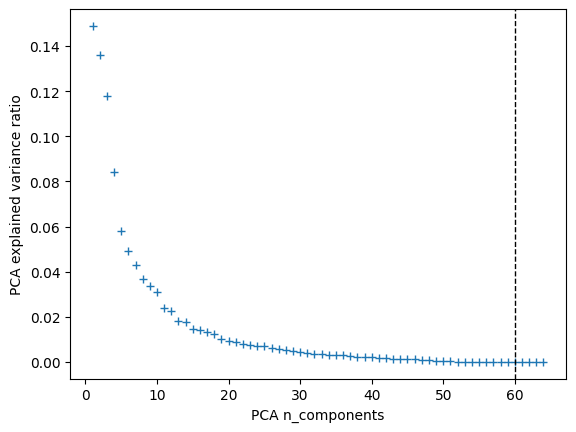

In [40]:
pca.fit(X_digits)

plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2)
plt.ylabel("PCA explained variance ratio")
plt.xlabel("PCA n_components")
plt.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    color='k', linewidth=1.0, linestyle='--',
    label="n_components chosen",
);

## La interfaz general del Pipeline

- La clase `Pipeline` no se limita al preprocesamiento y la clasificación, sino que puede unir cualquier número de estimadores. Por ejemplo, se puede construir una tubería que contenga la `extracción de características, la selección de características, el escalado y la clasificación`, para un total de cuatro pasos. Del mismo modo, el último paso podría ser la regresión o la agrupación en lugar de la clasificación. El único requisito para los estimadores en una línea de producción es que `todos los pasos, excepto el último, deben tener un método de transformación, de modo que puedan ser utilizados en el siguiente paso`.

- Internamente, durante la llamada a `Pipeline.fit`, la tubería llama a `fit` y luego a `transform` en cada paso, con la entrada dada por la salida del método de transformación del paso anterior. Para el último paso de la tubería, sólo se llama a fit. Repasando algunos detalles más finos, esto se implementa como sigue. Recuerde que la tubería `line.steps` es una lista de tuplas, por lo que `pipeline.steps[0][1]` es el primer estimador, `pipeline.steps[1][1]` es el segundo estimador, y así sucesivamente

In [41]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # Iterar sobre todo excepto el último paso 
        # Ajustar y transformar los datos
        X_transformed = estimator.fit_transform(X_transformed, y)
    # Ajuste en el último paso
    self.steps[-1][1].fit(X_transformed, y)
    return self

- Cuando se predice utilizando `Pipeline`, transformamos los datos de forma similar utilizando todos los pasos menos el último paso, y luego llamamos a `predict` en el último paso

In [42]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # Iterar sobre todo excepto el último paso 
        # Ajustar y transformar los datos
        X_transformed = step[1].transform(X_transformed)
    # Ajuste en el último paso
    return self.steps[-1][1].predict(X_transformed)

- El proceso se ilustra en la {numref}`pipeline_predict` para dos transformadores, `T1`, `T2`, y un `classifier` (llamado `Classifier`)

```{figure} ./imgs/pipeline_predict.png
:name: pipeline_predict
:align: center
:scale: 60

Visión general del proceso de entrenamiento y predicción de la tubería.
```

- En realidad, la tubería es aún más general que esto. No es necesario que el último paso de una tubería tenga una función de predicción, y `podríamos crear una tubería que sólo contenga, por ejemplo, un escalador y un PCA`. Entonces, como el último paso `(PCA)` tiene un método `transform`, podríamos llamar a `transform` en el `pipeline` para obtener el resultado de `PCA.transform` aplicado a los datos que fueron procesados por el paso anterior. Sólo se requiere que el último paso de un pipeline tenga un método de ajuste.

## Creación cómoda de pipelines con make_pipeline

- La creación de un `pipeline` utilizando la sintaxis descrita anteriormente es a veces un poco engorrosa, y a menudo no necesitamos nombres especificados por el usuario para cada paso. `Existe una función conveniente make_pipeline, que creará una tubería por nosotros y nombrará automáticamente cada paso basándose en su clase`. La sintaxis de `make_pipeline` es la siguiente

In [43]:
from sklearn.pipeline import make_pipeline

In [44]:
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

- Los objetos pipeline `pipe_long` y `pipe_short` hacen exactamente lo mismo, pero `pipe_short` tiene pasos que fueron nombrados automáticamente. Podemos ver los nombres de los pasos mirando el atributo `steps`

In [45]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


- Los pasos se denominan `minmaxscaler` y `svc`. En general, los nombres de los pasos son sólo versiones de los nombres de las clases. Si varios pasos tienen la misma clase, se añade un número

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [47]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


- Como puede ver, el primer paso de `StandardScaler` llamó `standardscaler-1` y el segundo `standardscaler-2`. Sin embargo, en este tipo de configuraciones podría ser mejor utilizar la construcción de tuberías con nombres explícitos, para dar nombres más semánticos a cada paso

## Acceso a los atributos de los pasos

- A menudo querrá inspeccionar los atributos de uno de los pasos de la tubería, por ejemplo, los coeficientes de un modelo lineal o los componentes extraídos por `PCA`. `La forma más fácil de acceder a los pasos de un pipeline es a través del atributo named_steps`, que es un diccionario de los nombres de los pasos a los estimadores. A continuación, se ajusta el `pipeline` definido anteriormente, al conjunto de datos `cancer` y extrae las dos primeros componentes principales del paso `pca`.

In [48]:
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


## Acceso a los atributos en un Pipeline con GridSearch

- Como hemos comentado anteriormente en este capítulo, una de las principales razones para utilizar `pipelines`, es para realizar búsquedas en la red. Una tarea común es acceder a algunos de los pasos de una tubería dentro de dentro de una búsqueda en red. Busquemos en la red un clasificador `LogisticRegression` en el conjunto de datos `cancer`, utilizando `Pipeline`. Usamos `StandardScaler`, para escalar los datos antes de pasarlos al clasificador `LogisticRegresión`. Primero creamos una instancia de nuestro `pipeline` usando la función `make_pipeline`.

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

- A continuación, creamos un grid de parámetros. Como se explica en la sección anterior, el parámetro de regularización para `LogisticRegression` es el parámetro `C`. Utilizamos una red logarítmica para este parámetro, buscando entre 0.01 y 100. Como utilizamos la función `make_pipeline`, el nombre del paso `LogisticRegression` en el `pipeline` es el nombre de la clase en minúsculas, `logisticregression`. Para afinar el parámetro `C`, tenemos que especificar una red de parámetros para `logisticregression__C`

In [51]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

- Como es habitual, dividimos el conjunto de datos `cancer` en conjuntos de entrenamiento y de prueba, y ajustamos una búsqueda en red

In [52]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

- Entonces, ¿cómo accedemos a los coeficientes del mejor modelo `LogisticRegression` que fue encontrado por `GridSearchCV`? De los capítulos anteriores sabemos que el mejor modelo encontrado por `GridSearchCV`, entrenado con todos los datos de entrenamiento, se almacena en `grid.best_estimator_`

In [53]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


- Este `best_estimator_` en nuestro caso es un `pipeline` con dos pasos, `standardcaler` y `logisticregression`. Para acceder al paso de `logisticregression`, podemos utilizar el atributo `named_steps` de la tubería, como se ha explicado anteriormente

In [54]:
print("Logistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1)


- Ahora que tenemos la instancia de `LogisticRegression` entrenada, podemos acceder a los coeficientes (pesos) asociados a cada característica de entrada. Para mas información sobre los parámetros que podemos visualizar de este modelo clasificador (ver [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). En este caso visualizaremos sus coeficientes usando `.coef_`. Puede que sea una expresión algo larga, pero a menudo resulta útil para entender los modelos.

In [55]:
print("Logistic regression coefficients:\n{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## Pasos de preprocesamiento GridSearch y Parámetros del Modelo 

- Usando `pipelines`, podemos encapsular todos los pasos de procesamiento en nuestro flujo de trabajo de aprendizaje automático en un único estimador de `scikit-learn`. Otro beneficio de hacer esto es que ahora podemos `ajustar los parámetros de preprocesamiento` usando el output de una tarea supervisada, como la regresión o la clasificación. En los capítulos anteriores, utilizamos las funciones polinómicas en el dataset `boston` antes de aplicar el `regresor ridge`. Vamos a modelar esto usando un pipeline en su lugar. El proceso contiene tres pasos: `escalar los datos, calcular las características polinómicas y la regresión ridge`

In [56]:
import pandas as pd

In [57]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=0)

In [59]:
from sklearn.preprocessing import PolynomialFeatures

In [60]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

- La clase `PolynomialFeatures`, se encarga de generar características polinómicas y de interacción. `Genera una nueva matriz de características que consiste en todas las combinaciones polinómicas de las características con grado menor o igual al grado especificado`. Por ejemplo, si una muestra de entrada es bidimensional y de la forma `[a, b]`, las características polinómicas de grado 2 son `[1, a, b, a^2, ab, b^2]`. ¿Cómo sabemos qué grados de polinomios elegir, o si hay que elegir algún polinomio o interacciones? `Lo ideal es seleccionar el parámetro de grado basado en el resultado de la clasificación`. Utilizando nuestro pipeline, podemos buscar sobre el parámetro `degree` junto con el parámetro `alpha` de `Ridge`. Para ello, definimos un `param_grid` que contenga ambos, debidamente prefijados por los nombres de los pasos

In [61]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

- Ahora podemos volver a ejecutar nuestra búsqueda en la red utilizando nuestro `param_grid`

In [62]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

- Podemos visualizar el resultado de la validación cruzada utilizando un mapa de calor (ver [matshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html)), como ya se hizo en anteriores secciones

In [63]:
import matplotlib.pyplot as plt

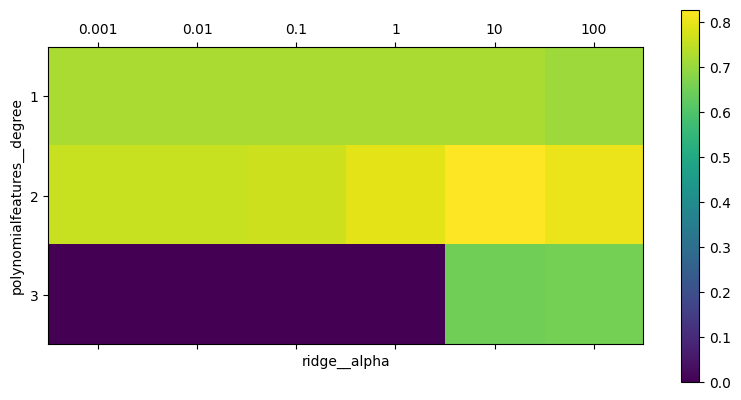

In [64]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree'])
plt.colorbar();

- Observando los resultados producidos por la validación cruzada, `podemos ver que el uso de polinomios de grado dos ayuda, pero que los polinomios de grado tres son mucho peores que los de grado uno o dos`. Esto se refleja en los mejores parámetros encontrados

In [65]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


- Lo que lleva al siguiente `score`

In [66]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


- Hagamos una búsqueda en red sin características polinómicas para comparar

In [67]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


- Como era de esperar al ver los resultados de la búsqueda en red visualizados, `el no uso de características polinómicas conduce a resultados decididamente peores. La búsqueda sobre los parámetros de preprocesamiento junto con los parámetros del modelo es una estrategia muy poderosa`. Sin embargo, hay que tener en cuenta que `GridSearchCV` prueba todas las combinaciones posibles de los parámetros especificados. Por lo tanto, si se añaden más parámetros a la red aumenta exponencialmente el número de modelos que hay que construir

## Grid-Searching Qué Modelo Usar

- Se puede ir más allá al combinar `GridSearchCV` y `Pipeline`: también es posible buscar sobre los pasos reales que se están realizando en el `pipeline` (por ejemplo, si se debe utilizar `StandardScaler` o `MinMaxScaler`). Esto conduce a un espacio de búsqueda aún mayor y debe considerarse cuidadosamente. Probar todas las soluciones posibles no suele ser una estrategia viable de aprendizaje automático. Sin embargo, aquí hay un ejemplo que compara un clasificador `RandomForest` y un `SVC` en el conjunto de datos `iris`. Sabemos que `SVC` podría necesitar que los datos sean escalados, por lo que también buscamos si se utiliza `StandardScaler` o no preprocesamiento. Para el `RandomForestClassifier`, sabemos que no es necesario el preprocesamiento. Comenzamos definiendo el `pipeline`. Aquí, nombramos explícitamente los pasos. Queremos dos pasos, uno para el preprocesamiento y luego un clasificador. Podemos instanciar esto utilizando `SVC` y `StandardScaler`

In [68]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

- Ahora podemos definir el `parameter_grid` para buscar sobre él. Queremos que el clasificador sea `RandomForestClassifier` o `SVC`. Debido a que tienen diferentes parámetros y necesitan un preprocesamiento diferente, podemos utilizar la lista de red de busqueda que discutimos en el capítulo anterior. Para asignar una estimación a un paso, utilizamos el nombre del paso como nombre del parámetro. Cuando queramos omitir un paso en la tubería (por ejemplo, porque no necesitamos el preprocesamiento para el `RandomForest`), podemos establecer ese paso como `None`

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
param_grid = [{'classifier': [SVC()], 
               'preprocessing': [StandardScaler(), None],
               'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier': [RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 
               'classifier__max_features': [1, 2, 3]}]

- Ahora podemos instanciar y ejecutar `grid search` como de costumbre, aquí en el conjunto de datos `cancer`. Nótes que solo es necesario inicializar `pipe` con cualquiera de los dos estimadores, luego `GridSearchCV` se encargará de seleccionar el mejor modelo, basado en el `param_grid` suministrado.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


- El resultado de la búsqueda en la red es que el `SVC` con el preprocesamiento `StandardScaler`, `C=10` y `gamma=0.01` dio el mejor resultado de clasificación, en comparación del el `RandomForestClassifier`.

## Resumen y conclusiones

- En este capítulo hemos introducido la clase `Pipeline`, una herramienta de propósito general para `encadenar múltiples pasos de procesamiento en un flujo de trabajo de aprendizaje automático`. Las aplicaciones del mundo real del aprendizaje automático rara vez implican el uso aislado de un modelo, y en su lugar son una secuencia de pasos de procesamiento. El uso de `pipelines` nos permite encapsular múltiples pasos en un solo objeto de `Python` que se adhiere a la interfaz familiar de `scikit-learn` de `ajustar, predecir y transformar`. En particular, cuando se realiza la evaluación del modelo mediante la validación cruzada y la selección de parámetros mediante la búsqueda en red, el uso de la clase `Pipeline` para captar todos los pasos de procesamiento es esencial para una evaluación adecuada. 

- `La clase Pipeline también permite escribir un código más resumido, y reduce la probabilidad de errores que pueden ocurrir al construir cadenas de procesamiento sin la clase Pipeline` (como olvidar de aplicar todos los transformadores en el conjunto de prueba, o no aplicarlos en el orden correcto). La elección de la combinación correcta de extracción de características, preprocesamiento y modelos, es un arte, y a menudo requiere un poco de ensayo y error.  Sin embargo, utilizando `pipelines`, este "ensayo" de muchos pasos de procesamiento diferentes es bastante sencillo. `Cuando experimenta su uso, tenga cuidado de no complicar demasiado sus procesos y asegúrese de evaluar si todos los componentes que se incluyen en el modelo son necesarios`.

- Con este capítulo, hemos completado nuestro estudio de las herramientas de propósito general y los algoritmos proporcionados por `scikit-learn`. `Ahora posee todas las habilidades requeridas y conoce los mecanismos necesarios para aplicar el aprendizaje automático en la práctica`. En la siguiente sección resolveremos un problema de aplicación, en el que pongamos en practica, algunas de las técnicas abordadas a traves del curso. 